In [10]:
import sys
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Optional deps
try:
    from umap import UMAP
    UMAP_OK = True
except Exception:
    try:
        from umap.umap_ import UMAP
        UMAP_OK = True
    except Exception:
        UMAP_OK = False

try:
    from scipy.stats import mannwhitneyu, ks_2samp
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

# ML stack
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, 
    train_test_split
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score, confusion_matrix, roc_curve,
    accuracy_score
)
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import loguniform
import joblib

from xgboost import XGBClassifier
import xgboost as xgb  # for early stopping via xgb.train

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

from datetime import datetime

# Plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# === 基本資料夾設定 ===
BASE_DIR = Path(r"D:\FLY114")
XLSX_PATH = BASE_DIR / "Diagnosis and autonomic marker data for VNS research_20250813.xlsx"

# === 產生唯一執行資料夾（包含時間戳） ===
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_DIR = BASE_DIR / f"Run_{timestamp}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

# === 子資料夾 ===
PLOTS_DIR = RUN_DIR / "plots"
MODELS_DIR = RUN_DIR / "models"
for d in [PLOTS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# === Excel 輸出檔 ===
OUT_XLSX = RUN_DIR / f"enhanced_analysis_summary_{timestamp}.xlsx"
SHEET_NAME = "Sheet1"

print("=" * 80)
print(f"✅ 本次分析輸出將儲存在：{RUN_DIR}")
print(f"📊 Excel 結果檔：{OUT_XLSX.name}")
print(f"🖼️ 圖片輸出資料夾：{PLOTS_DIR.name}")
print(f"🧠 模型輸出資料夾：{MODELS_DIR.name}")
print("=" * 80)

# ==================== Columns ====================
BASIC_COLS   = ["Age", "Sex", "BMI"]
LABEL_COLS   = ["SSD", "MDD", "Panic", "GAD"]
CONTROL_COLS = ["DM", "TCA", "MARTA"]
HRV_COLS     = ["SDNN", "LF", "HF", "LFHF", "SC", "FT", "RSA"]
ALL_FEATURES = BASIC_COLS + CONTROL_COLS + HRV_COLS  # ← 不做任何特徵工程

print("=" * 80)
print("FLY114：乾淨基線版（無特徵工程；PCA 不做 log；XGB EarlyStopping；SMOTE/CW 對照）")
print("=" * 80)

✅ 本次分析輸出將儲存在：D:\FLY114\Run_20251015_095758
📊 Excel 結果檔：enhanced_analysis_summary_20251015_095758.xlsx
🖼️ 圖片輸出資料夾：plots
🧠 模型輸出資料夾：models
FLY114：乾淨基線版（無特徵工程；PCA 不做 log；XGB EarlyStopping；SMOTE/CW 對照）


In [11]:
# ==================== 1. Load ====================
print("\n[1] 載入資料…")
df = pd.read_excel(XLSX_PATH, sheet_name=SHEET_NAME)
df.columns = [c.strip() for c in df.columns]
print(f"原始資料形狀: {df.shape}")


[1] 載入資料…
原始資料形狀: (502, 17)


In [12]:
# ==================== 2. Basic cleaning ====================
print("\n[2] 基本清理…")
for c in [*ALL_FEATURES, *LABEL_COLS]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Sex to 0/1 when possible
if "Sex" in df.columns and (df["Sex"].dtype == object or df["Sex"].nunique(dropna=True) > 2):
    norm = df["Sex"].astype(str).str.lower().str[0].map({"m":1, "f":0})
    if norm.notna().mean() > 0.6:
        df["Sex"] = norm

# LFHF >= 0
if "LFHF" in df.columns:
    df.loc[df["LFHF"] < 0, "LFHF"] = np.nan

# IQR-based outlier -> NaN on numeric HRV + Age/BMI
def remove_outliers_iqr(df, cols, factor=3.0):
    df_clean = df.copy()
    for col in cols:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - factor * IQR
            upper = Q3 + factor * IQR
            outliers = ((df_clean[col] < lower) | (df_clean[col] > upper))
            if outliers.any():
                df_clean.loc[outliers, col] = np.nan
    return df_clean

numerical_cols = [c for c in HRV_COLS + ["Age", "BMI"] if c in df.columns]
df = remove_outliers_iqr(df, numerical_cols, factor=3.0)
print(f"清理後資料形狀: {df.shape}")


[2] 基本清理…
清理後資料形狀: (502, 17)


In [13]:
# ==================== 3. Missing overview ====================
print("\n[3] 缺失值概覽…")
feat_available = [c for c in ALL_FEATURES if c in df.columns]
missing_report = pd.DataFrame({
    'column': feat_available,
    'missing_count': [df[c].isna().sum() for c in feat_available],
    'missing_ratio': [df[c].isna().mean() for c in feat_available]
}).sort_values('missing_ratio', ascending=False)
print(missing_report)
for label in LABEL_COLS:
    if label in df.columns:
        mask = df[label].notna()
        print(f"  {label}: {mask.sum()} 個有效樣本")


[3] 缺失值概覽…
   column  missing_count  missing_ratio
7      LF             53       0.105578
8      HF             51       0.101594
9    LFHF             28       0.055777
12    RSA             25       0.049801
6    SDNN             24       0.047809
10     SC             19       0.037849
2     BMI              2       0.003984
11     FT              1       0.001992
0     Age              0       0.000000
1     Sex              0       0.000000
3      DM              0       0.000000
4     TCA              0       0.000000
5   MARTA              0       0.000000
  SSD: 502 個有效樣本
  MDD: 502 個有效樣本
  Panic: 502 個有效樣本
  GAD: 502 個有效樣本



[4] PCA (no log)...

PCA Explained Variance:
    PC  Explained_Variance_Ratio  Cumulative_Variance
0  PC1                  0.557316             0.557316
1  PC2                  0.163877             0.721193
2  PC3                  0.125902             0.847095
3  PC4                  0.077201             0.924296
4  PC5                  0.039472             0.963768
5  PC6                  0.022317             0.986085
6  PC7                  0.013915             1.000000

PCA Loading Matrix（每個主成分對應各 HRV 特徵的權重）:
         PC1     PC2     PC3     PC4     PC5     PC6     PC7
SDNN  0.5120  0.0315 -0.0081  0.0074  0.0614  0.2082  0.8304
LF    0.5091  0.2522 -0.0076  0.0989 -0.1092  0.6521 -0.4798
HF    0.5435 -0.1252 -0.0058  0.1905 -0.5238 -0.5981 -0.1434
LFHF -0.0692  0.9576 -0.0448 -0.0189 -0.0263 -0.2637  0.0742
SC   -0.0005  0.0427  0.9831 -0.1504 -0.0939  0.0122  0.0135
FT   -0.0991  0.0211  0.1665  0.9518  0.2335 -0.0064  0.0377
RSA   0.4107 -0.0195  0.0608 -0.1577  0.8037 -0.3225 -

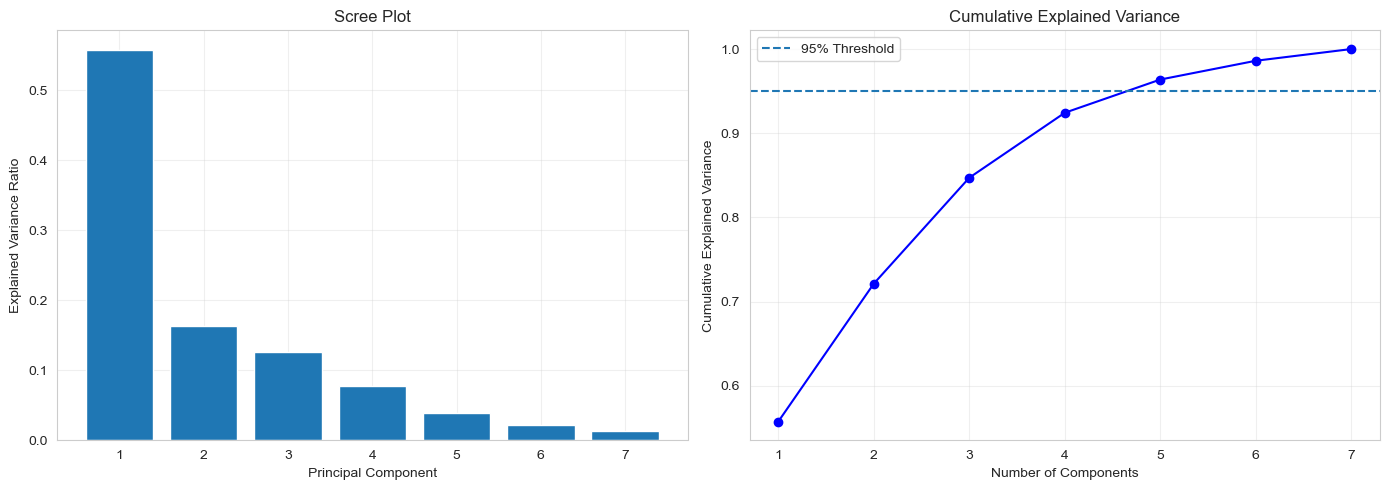

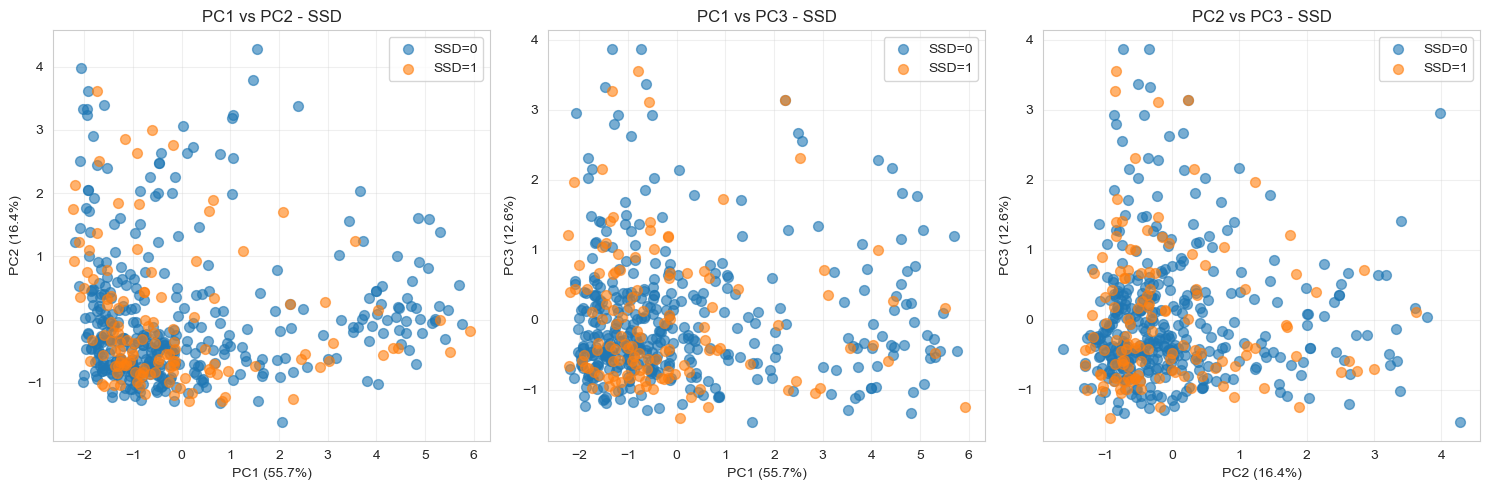

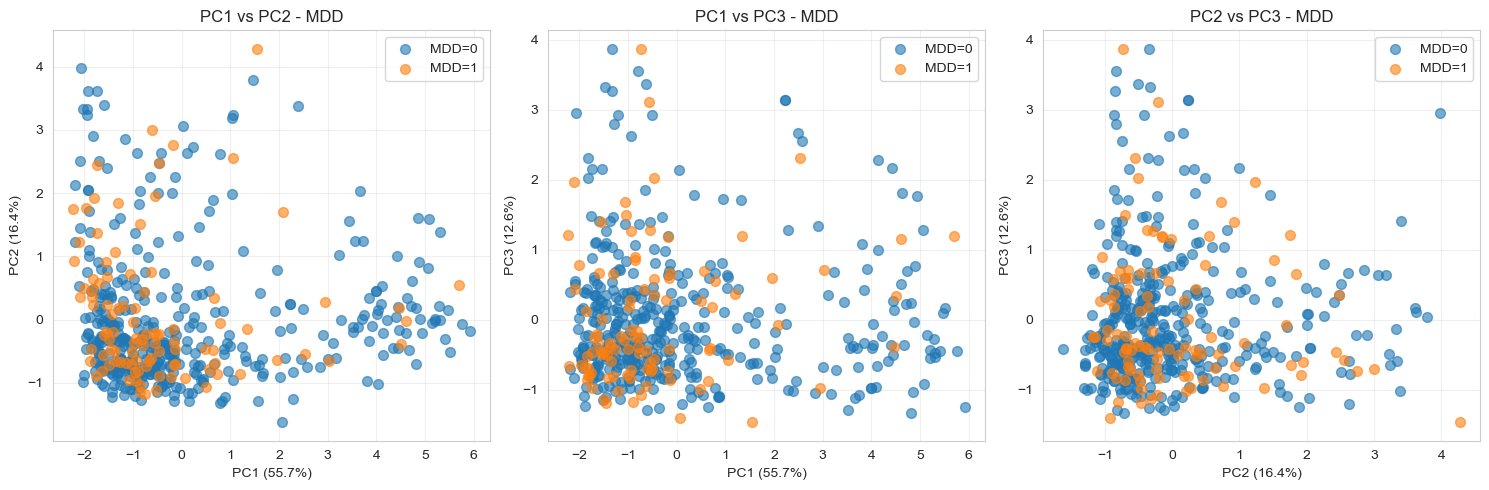

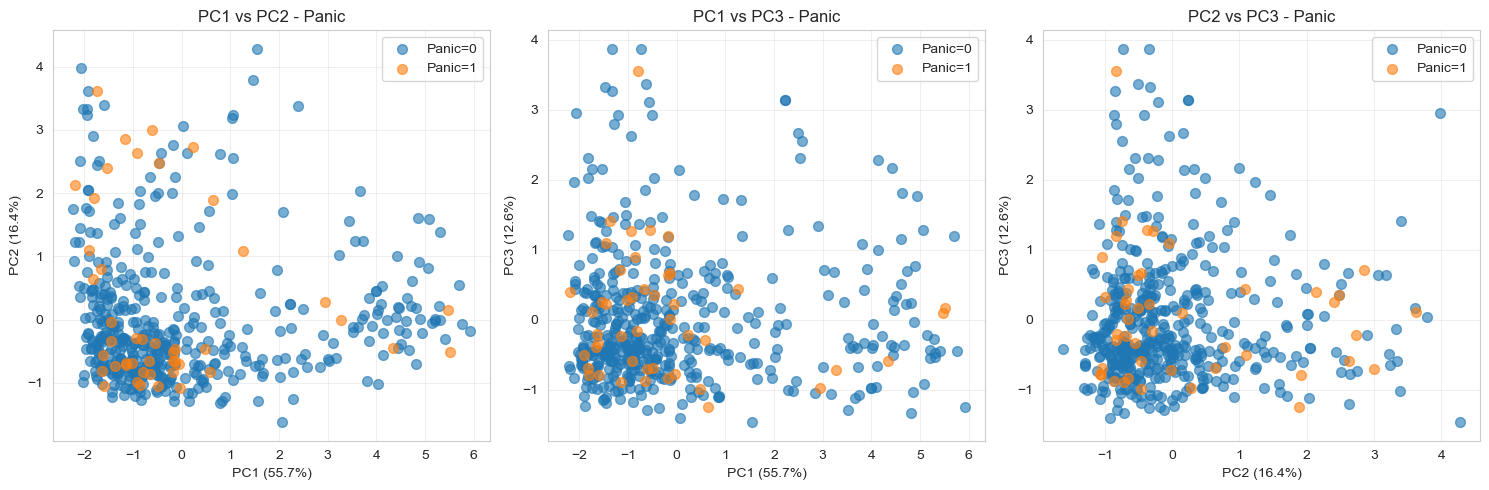

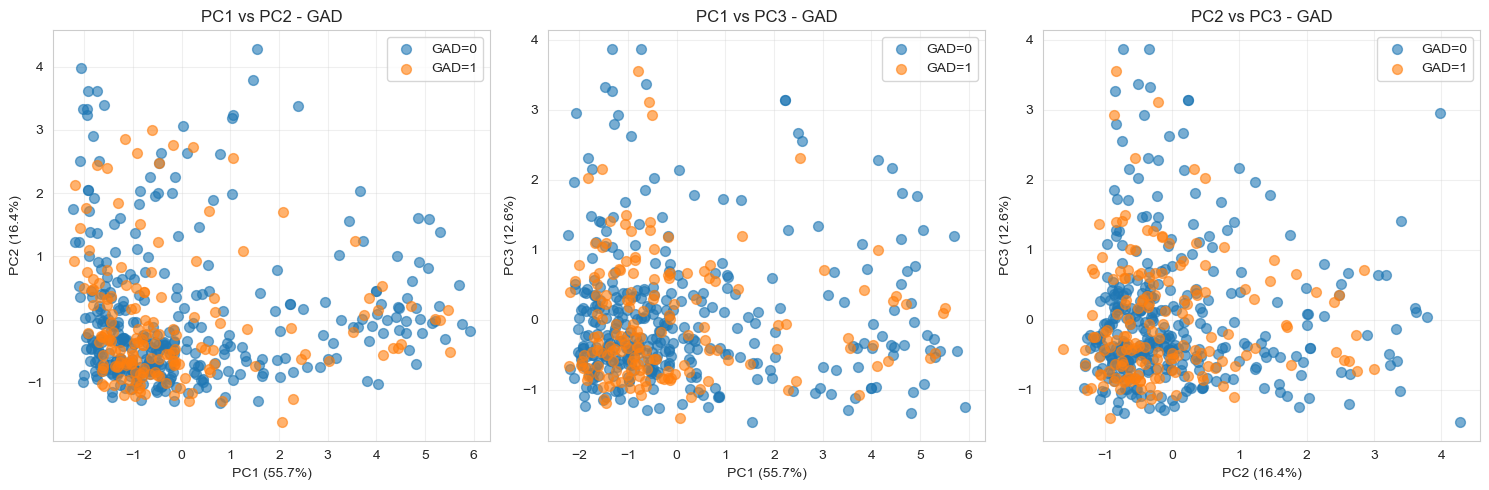


🔧 PCA 分支將使用前 3 個元件做分類：['PC1', 'PC2', 'PC3']


In [14]:
# ==================== 4. PCA (no log) ====================
print("\n[4] PCA (no log)...")
hrv_cols_available = [c for c in HRV_COLS if c in df.columns]
X_pca = df[hrv_cols_available].copy()

# KNNImputer + RobustScaler only
imp = KNNImputer(n_neighbors=5)
X_pca_filled = pd.DataFrame(imp.fit_transform(X_pca), columns=X_pca.columns, index=X_pca.index)
scaler = RobustScaler()
X_pca_scaled = scaler.fit_transform(X_pca_filled)

pca = PCA(random_state=42)
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# === Explained Variance Summary ===
explained_var = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained_Variance_Ratio': pca.explained_variance_ratio_,
    'Cumulative_Variance': np.cumsum(pca.explained_variance_ratio_)
})
print("\nPCA Explained Variance:")
print(explained_var.head(10))

# === PCA Loading Matrix（特徵權重表）===
loading_matrix = pd.DataFrame(
    pca.components_.T,
    index=hrv_cols_available,
    columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
)

print("\nPCA Loading Matrix（每個主成分對應各 HRV 特徵的權重）:")
print(loading_matrix.round(4))

# === 分析前 3 個主成分的主導特徵 ===
for i in range(min(3, loading_matrix.shape[1])):
    pc_name = f"PC{i+1}"
    sorted_features = loading_matrix[pc_name].abs().sort_values(ascending=False)
    top_features = sorted_features.head(3).index.tolist()
    print(f"\n🔹 {pc_name} 主要由以下特徵主導：{', '.join(top_features)}")

# === 將 Loading Matrix 輸出到 Excel ===
pca_loading_path = PLOTS_DIR / "pca_loading_matrix.xlsx"
loading_matrix.to_excel(pca_loading_path)
print(f"\n✅ PCA Loading Matrix 已輸出至：{pca_loading_path}")

# --- Scree Plot & Cumulative Variance ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.bar(range(1, min(11, len(pca.explained_variance_ratio_)+1)), pca.explained_variance_ratio_[:10])
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), 'bo-')
ax2.axhline(y=0.95, linestyle='--', label='95% Threshold')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / "pca_variance_explained.png", dpi=300, bbox_inches='tight')
plt.show()

# --- 2D / 3D Visualization for Each Label ---
for label in LABEL_COLS:
    if label not in df.columns: 
        continue
    fig = plt.figure(figsize=(15, 5))

    mask0 = df[label] == 0
    mask1 = df[label] == 1

    # PC1 vs PC2
    ax1 = fig.add_subplot(131)
    ax1.scatter(X_pca_transformed[mask0, 0], X_pca_transformed[mask0, 1], alpha=0.6, label=f'{label}=0', s=50)
    ax1.scatter(X_pca_transformed[mask1, 0], X_pca_transformed[mask1, 1], alpha=0.6, label=f'{label}=1', s=50)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax1.set_title(f'PC1 vs PC2 - {label}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # PC1 vs PC3
    if len(pca.explained_variance_ratio_) >= 3:
        ax2 = fig.add_subplot(132)
        ax2.scatter(X_pca_transformed[mask0, 0], X_pca_transformed[mask0, 2], alpha=0.6, label=f'{label}=0', s=50)
        ax2.scatter(X_pca_transformed[mask1, 0], X_pca_transformed[mask1, 2], alpha=0.6, label=f'{label}=1', s=50)
        ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax2.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
        ax2.set_title(f'PC1 vs PC3 - {label}')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # PC2 vs PC3
        ax3 = fig.add_subplot(133)
        ax3.scatter(X_pca_transformed[mask0, 1], X_pca_transformed[mask0, 2], alpha=0.6, label=f'{label}=0', s=50)
        ax3.scatter(X_pca_transformed[mask1, 1], X_pca_transformed[mask1, 2], alpha=0.6, label=f'{label}=1', s=50)
        ax3.set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        ax3.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
        ax3.set_title(f'PC2 vs PC3 - {label}')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"pca_3d_analysis_{label}.png", dpi=300, bbox_inches='tight')
    plt.show()

# === 將前幾個 PCA 元件加入 df 以利模型訓練（PCA 分支使用） ===
cumvar = np.cumsum(pca.explained_variance_ratio_)
k95 = int(np.searchsorted(cumvar, 0.85) + 1) if len(cumvar) > 0 else 0
PCA_TOP_K = min(3, k95) if k95 > 0 else min(3, X_pca_transformed.shape[1])
pca_cols = [f"PC{i+1}" for i in range(PCA_TOP_K)]
df_pca_comp = pd.DataFrame(X_pca_transformed[:, :PCA_TOP_K], columns=pca_cols, index=df.index)
df = pd.concat([df, df_pca_comp], axis=1)
print(f"\n🔧 PCA 分支將使用前 {PCA_TOP_K} 個元件做分類：{pca_cols}")

In [15]:
# ==================== 5. Feature importance (RF + MI) ====================
print("\n[5] 特徵重要性分析…")
from sklearn.feature_selection import mutual_info_classif
feature_importance_results = {}
rf_topk_map = {}  # << 供各標籤分類時使用 RF-TopK 分支
RF_TOP_K = 5

for label in LABEL_COLS:
    if label not in df.columns:
        continue
    mask = df[label].notna()
    available_features = [c for c in ALL_FEATURES if c in df.columns]
    if len(available_features) == 0:
        continue

    X = df.loc[mask, available_features].copy()
    y = df.loc[mask, label].values

    # 缺失補值
    imp_local = KNNImputer(n_neighbors=5)
    X_filled = pd.DataFrame(imp_local.fit_transform(X), columns=X.columns)

    # 樣本檢查
    if len(np.unique(y)) < 2 or len(X) < 20:
        continue

    # MI 與 RF 重要性
    mi_scores = mutual_info_classif(X_filled, y, random_state=42)
    rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    rf.fit(X_filled, y)
    rf_importance = rf.feature_importances_

    # 正規化後做綜合分數
    mi_norm = mi_scores / (np.max(mi_scores) + 1e-12)
    rf_norm = rf_importance / (np.max(rf_importance) + 1e-12)

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'mutual_info': mi_scores,
        'rf_importance': rf_importance,
        'combined_score': (mi_norm + rf_norm) / 2.0
    }).sort_values('combined_score', ascending=False)

    feature_importance_results[label] = importance_df

    print(f"\n{label} 特徵重要性 (Top 10):")
    print(importance_df.head(10))

    # === 各指標分別輸出三張 PNG：MI / RF / Combined ===
    top_n = min(15, len(importance_df))

    # 依各指標排序後取前 top_n
    mi_sorted   = importance_df.sort_values('mutual_info',   ascending=False).head(top_n)
    rf_sorted   = importance_df.sort_values('rf_importance', ascending=False).head(top_n)
    comb_sorted = importance_df.sort_values('combined_score', ascending=False).head(top_n)

    # 供 RF-TopK 分支使用：取 RF 重要度前 K
    rf_topk_map[label] = list(rf_sorted['feature'].head(RF_TOP_K))

    # 1) MI 單張圖
    plt.figure(figsize=(8, 6))
    plt.barh(mi_sorted['feature'], mi_sorted['mutual_info'])
    plt.gca().invert_yaxis()
    plt.xlabel('Mutual Information')
    plt.title(f'{label} - Feature Importance (MI)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"feature_importance_MI_{label}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 2) RF 單張圖
    plt.figure(figsize=(8, 6))
    plt.barh(rf_sorted['feature'], rf_sorted['rf_importance'])
    plt.gca().invert_yaxis()
    plt.xlabel('Random Forest Importance')
    plt.title(f'{label} - Feature Importance (RF)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"feature_importance_RF_{label}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 3) 綜合分數（MI 與 RF 正規化平均）
    plt.figure(figsize=(8, 6))
    plt.barh(comb_sorted['feature'], comb_sorted['combined_score'])
    plt.gca().invert_yaxis()
    plt.xlabel('Combined Score (normalized MI & RF avg)')
    plt.title(f'{label} - Feature Importance (Combined)')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f"feature_importance_Combined_{label}.png", dpi=300, bbox_inches='tight')
    plt.close()


[5] 特徵重要性分析…

SSD 特徵重要性 (Top 10):
   feature  mutual_info  rf_importance  combined_score
2      BMI     0.021110       0.153820        0.824292
12     RSA     0.018757       0.102611        0.621697
9     LFHF     0.015830       0.095721        0.554336
5    MARTA     0.032547       0.002467        0.508019
11      FT     0.000000       0.124939        0.406119
6     SDNN     0.001466       0.104015        0.360630
8       HF     0.000000       0.102988        0.334765
10      SC     0.000000       0.099141        0.322262
7       LF     0.000000       0.096773        0.314565
4      TCA     0.018212       0.005539        0.297789

MDD 特徵重要性 (Top 10):
   feature  mutual_info  rf_importance  combined_score
8       HF     0.025837       0.113255        0.875831
5    MARTA     0.034373       0.033831        0.649356
0      Age     0.007273       0.110010        0.591460
11      FT     0.005765       0.111467        0.575962
2      BMI     0.005465       0.111817        0.573151
10      S

In [16]:
# ==================== 6. Classification（AUC + ACC；All / RF-TopK + PCA(PIPELINE)；SMOTE in-pipeline） ====================
print("\n[6] 二元分類（AUC + ACC；All / RF-TopK + PCA(PIPELINE)；SMOTE in-pipeline）…")

def enhanced_binary_classification(
    df, label, feature_cols,
    rf_topk_map=None,
    rf_k=5,
    n_iter=40, random_state=42
):
    """
    - 兩種特徵組合：
        A) All 全特徵
        B) RF-TopK + PCA：HRV 走 PCA；TopK 的非 HRV 欄位 passthrough
    - 不平衡處理：
        Panic → SMOTE（進 pipeline，pre 之後）
        MDD/SSD → class_weight='balanced'
    - 評估只回傳/繪圖：AUC, ACC
    - 加入 XGBoost（自動設定 scale_pos_weight）
    """
    if rf_topk_map is None:
        rf_topk_map = {}

    results = {}

    # --- 評估工具（AUC+ACC + ROC圖） ---
    def evaluate_and_plot(name, estimator, X_train, y_train, X_test, y_test, label, suffix):
        y_prob_train = estimator.predict_proba(X_train)[:, 1]
        y_pred_train = (y_prob_train >= 0.5).astype(int)
        y_prob_test  = estimator.predict_proba(X_test)[:, 1]
        y_pred_test  = (y_prob_test  >= 0.5).astype(int)

        train_auc = roc_auc_score(y_train, y_prob_train)
        test_auc  = roc_auc_score(y_test,  y_prob_test)
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc  = accuracy_score(y_test,  y_pred_test)

        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, lw=2, label=f"Test AUC={test_auc:.3f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC - {label} - {name} ({suffix})')
        plt.legend(loc='lower right'); plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / f"ROC_{label}_{name.replace(' ','_')}_{suffix}.png", dpi=300, bbox_inches='tight')
        plt.close()

        return {
            "train_auc": float(train_auc),
            "train_acc": float(train_acc),
            "test_auc":  float(test_auc),
            "test_acc":  float(test_acc)
        }

    # --- 依 label 套 class_weight（搭配 SMOTE 仍可保留） ---
    def build_models_for_label(label, random_state):
        cw = 'balanced'
        return {
            "Logistic Regression": LogisticRegression(
                max_iter=2000, random_state=random_state, class_weight=cw
            ),
            "Random Forest": RandomForestClassifier(
                random_state=random_state, n_jobs=-1, class_weight=cw
            ),
            "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
            "SVM": SVC(probability=True, random_state=random_state, class_weight=cw),
            "XGBoost": XGBClassifier(
                use_label_encoder=False,
                eval_metric="auc",
                random_state=random_state,
                n_estimators=300,
                learning_rate=0.05,
                max_depth=5,
                subsample=0.8,
                colsample_bytree=0.8
                # scale_pos_weight 之後依 y_train 動態設定
            )
        }

    # --- 超參空間 ---
    param_spaces_base = {
        "Logistic Regression": {"clf__C": loguniform(1e-3, 1e2)},
        "Random Forest": {"clf__n_estimators": [200, 400, 800]},
        "Gradient Boosting": {"clf__n_estimators": [100, 200, 400]},
        "SVM": {"clf__C": loguniform(1e-2, 1e2)},
        "XGBoost": {
            "clf__max_depth": [3, 4, 5, 6],
            "clf__learning_rate": loguniform(0.01, 0.2),
        }
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # === A) All：全部原始特徵 ===
    def run_all_features():
        mask = df[label].notna()
        X = df.loc[mask, [c for c in feature_cols if c in df.columns]].copy()
        y = df.loc[mask, label].astype(int).values
        if len(np.unique(y)) < 2 or len(X) < 60:
            return

        # 欄位分群
        cat_cols = [c for c in ['Sex','DM','TCA','MARTA'] if c in X.columns]
        num_cols = [c for c in X.columns if c not in cat_cols]

        # 前處理
        numeric_pipe = Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("scaler",  RobustScaler())
        ])
        cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent"))])
        pre_all = ColumnTransformer(
            [("num", numeric_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
            remainder="drop"
        )

        # Hold-out split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )

        # Selector（用 RF）
        selector = SelectFromModel(
            RandomForestClassifier(
                n_estimators=400, random_state=random_state,
                n_jobs=-1, class_weight="balanced"
            ),
            threshold="median"
        )

        # 針對此 label 構建模型（含 class_weight）
        models = build_models_for_label(label, random_state)

        for name, clf in models.items():
            # XGBoost 動態設定 scale_pos_weight
            if name == "XGBoost":
                pos = np.sum(y_train == 1)
                neg = np.sum(y_train == 0)
                spw = float(neg) / (float(pos) + 1e-6) if pos > 0 else 1.0
                clf.set_params(scale_pos_weight=spw)

            # === 重要：SMOTE 放在 pre 後面（避免 NaN）===
            pipe = ImbPipeline([
                ("pre", pre_all),
                ("smote", SMOTE(random_state=random_state)),
                ("select", selector),
                ("clf", clf)
            ])

            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_spaces_base.get(name, {}),
                n_iter=n_iter, scoring="roc_auc", cv=cv,
                n_jobs=-1, random_state=random_state, refit=True, verbose=0
            )
            search.fit(X_train, y_train)

            results[f"{name} (AUC+ACC) [All]"] = evaluate_and_plot(
                name, search.best_estimator_, X_train, y_train, X_test, y_test, label, "AUC+ACC_All"
            )

    # === B) RF-TopK + PCA（PIPELINE；HRV→PCA，TopK 非 HRV passthrough） ===
    def run_rf_topk_pca():
        topk_raw = [c for c in rf_topk_map.get(label, [])[:rf_k] if c in df.columns]
        hrv_cols_all = [c for c in HRV_COLS if c in df.columns]
        if len(topk_raw) == 0 or len(hrv_cols_all) < 2:
            return

        mask = df[label].notna()
        hrv_cols = [c for c in hrv_cols_all if c in df.columns]
        topk_non_hrv = [c for c in topk_raw if c not in hrv_cols]
        use_cols = list(dict.fromkeys(hrv_cols + topk_non_hrv + ['Sex','DM','TCA','MARTA']))
        X = df.loc[mask, [c for c in use_cols if c in df.columns]].copy()
        y = df.loc[mask, label].astype(int).values
        if len(np.unique(y)) < 2 or len(X) < 60:
            return

        # 依實際欄位再分
        hrv_cols = [c for c in hrv_cols if c in X.columns]
        cat_cols = [c for c in ['Sex','DM','TCA','MARTA'] if c in X.columns]
        num_pass_cols = [c for c in topk_non_hrv if c in X.columns and c not in cat_cols]

        # HRV→PCA 分支（會在 CV 訓練折 fit，避免洩漏）
        pca_pipe = Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("scaler",  RobustScaler()),
            ("pca",     PCA(n_components=min(3, max(2, len(hrv_cols))), random_state=random_state))
        ])
        num_pass_pipe = Pipeline([
            ("imputer", KNNImputer(n_neighbors=5)),
            ("scaler",  RobustScaler())
        ])
        cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent"))])

        pre_rf_topk_pca = ColumnTransformer(
            transformers=[
                ("hrv_pca", pca_pipe, hrv_cols),
                ("num_pass", num_pass_pipe, num_pass_cols),
                ("cat_pass", cat_pipe, cat_cols)
            ],
            remainder="drop"
        )

        # Hold-out split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )

        selector = SelectFromModel(
            RandomForestClassifier(
                n_estimators=400, random_state=random_state,
                n_jobs=-1, class_weight="balanced"
            ),
            threshold="median"
        )

        # HRV 欄位數量決定 PCA 候選維度
        max_pca = min(5, max(2, len(hrv_cols)))
        pca_candidates = list(range(2, max_pca + 1))

        models = build_models_for_label(label, random_state)
        use_smote = (label == "Panic")

        for name, clf in models.items():
            if name == "XGBoost":
                pos = np.sum(y_train == 1)
                neg = np.sum(y_train == 0)
                spw = float(neg) / (float(pos) + 1e-6) if pos > 0 else 1.0
                clf.set_params(scale_pos_weight=spw)

            if use_smote:
                pipe = ImbPipeline([
                    ("pre", pre_rf_topk_pca),
                    ("smote", SMOTE(random_state=random_state)),
                    ("select", selector),
                    ("clf", clf)
                ])
            else:
                pipe = Pipeline([
                    ("pre", pre_rf_topk_pca),
                    ("select", selector),
                    ("clf", clf)
                ])

            # 在 CV 內同時調 PCA 維度與模型超參
            param_dist = dict(param_spaces_base.get(name, {}))
            param_dist["pre__hrv_pca__pca__n_components"] = pca_candidates

            search = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=param_dist,
                n_iter=n_iter, scoring="roc_auc", cv=cv,
                n_jobs=-1, random_state=random_state, refit=True, verbose=0
            )
            search.fit(X_train, y_train)

            results[f"{name} (AUC+ACC) [RFTopK+PCApipe]"] = evaluate_and_plot(
                name, search.best_estimator_, X_train, y_train, X_test, y_test, label, "AUC+ACC_RFTopK+PCApipe"
            )

    # === 執行兩個特徵組合 ===
    run_all_features()
    run_rf_topk_pca()

    return results


# Run all labels
all_classification_results = {}
for label in LABEL_COLS:
    if label not in df.columns:
        continue
    print(f"\n處理 {label}…")
    available_features = [c for c in ALL_FEATURES if c in df.columns]
    results_all = enhanced_binary_classification(
        df, label, available_features,
        rf_topk_map=rf_topk_map,
        rf_k=RF_TOP_K,
        n_iter=40,
        random_state=42
    )
    if results_all:
        all_classification_results[label] = results_all


[6] 二元分類（AUC + ACC；All / RF-TopK + PCA(PIPELINE)；SMOTE in-pipeline）…

處理 SSD…

處理 MDD…

處理 Panic…

處理 GAD…



[7] 結果彙整（Train/Test AUC + Accuracy）…

完整模型比較：
Label                                          Model Train_AUC Train_ACC Test_AUC Test_ACC
  SSD            Logistic Regression (AUC+ACC) [All]     0.648     0.571    0.605    0.515
  SSD                  Random Forest (AUC+ACC) [All]     1.000     1.000    0.594    0.614
  SSD              Gradient Boosting (AUC+ACC) [All]     0.989     0.933    0.604    0.604
  SSD                            SVM (AUC+ACC) [All]     0.791     0.703    0.585    0.554
  SSD                        XGBoost (AUC+ACC) [All]     1.000     0.998    0.587    0.574
  SSD Logistic Regression (AUC+ACC) [RFTopK+PCApipe]     0.648     0.581    0.635    0.584
  SSD       Random Forest (AUC+ACC) [RFTopK+PCApipe]     1.000     1.000    0.489    0.673
  SSD   Gradient Boosting (AUC+ACC) [RFTopK+PCApipe]     0.993     0.920    0.530    0.703
  SSD                 SVM (AUC+ACC) [RFTopK+PCApipe]     0.762     0.753    0.575    0.752
  SSD             XGBoost (AUC+ACC) [RFTopK

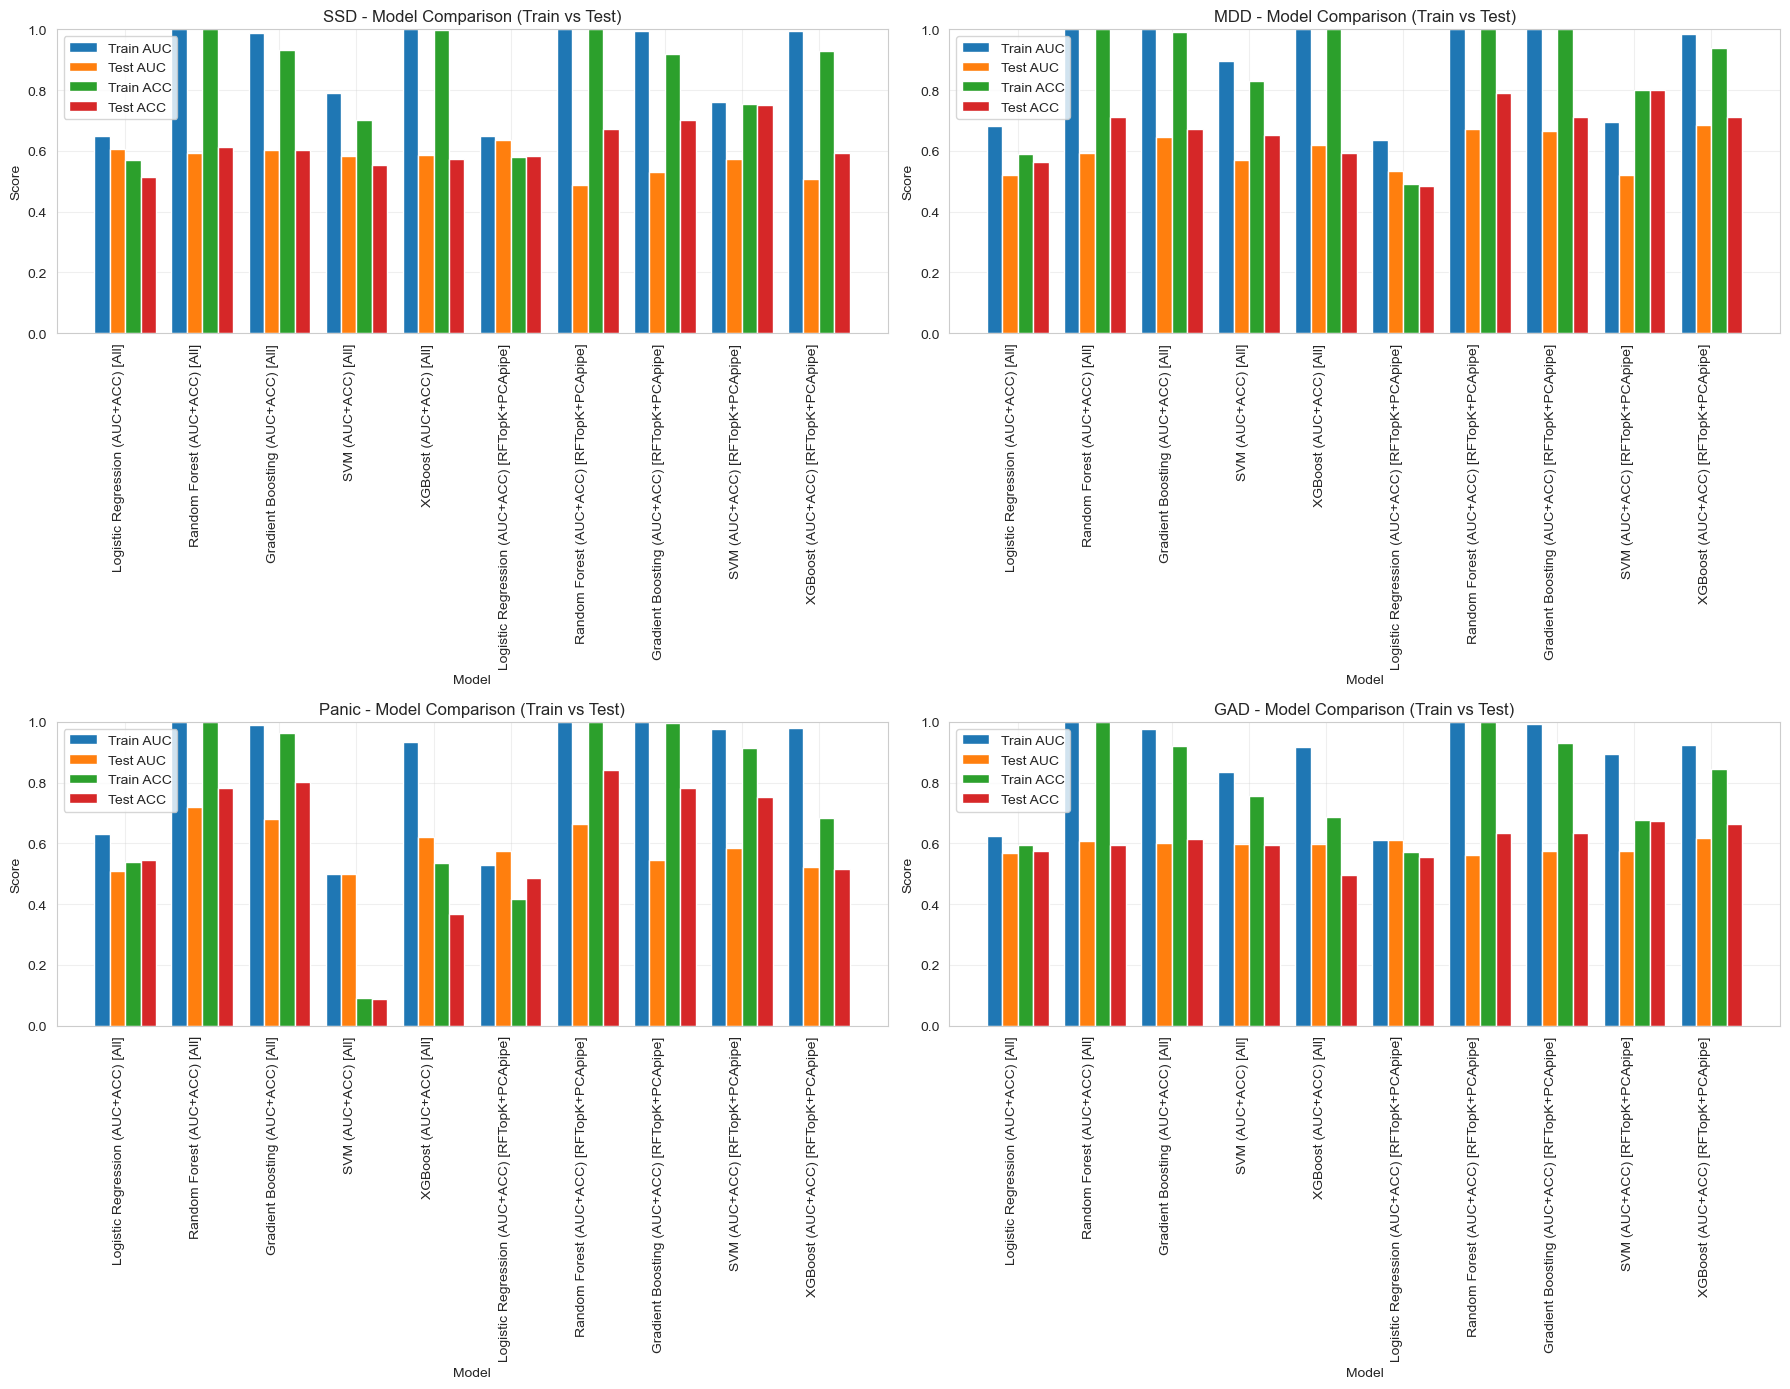

In [17]:
# ==================== 7. Summary & plots (Train/Test AUC + ACC) ====================
print("\n[7] 結果彙整（Train/Test AUC + Accuracy）…")

comparison_rows = []
for label, model_results in all_classification_results.items():
    for model_name, metrics in model_results.items():
        comparison_rows.append({
            'Label': label,
            'Model': model_name,
            'Train_AUC': f"{metrics.get('train_auc', float('nan')):.3f}",
            'Train_ACC': f"{metrics.get('train_acc', float('nan')):.3f}",
            'Test_AUC': f"{metrics.get('test_auc', float('nan')):.3f}",
            'Test_ACC': f"{metrics.get('test_acc', float('nan')):.3f}"
        })

comparison_df = pd.DataFrame(comparison_rows)

if not comparison_df.empty:
    print("\n完整模型比較：")
    print(comparison_df.to_string(index=False))
else:
    print("（尚無可用的模型結果）")

# === Plot per-label AUC vs Accuracy (Train/Test) ===
if not comparison_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.ravel()

    for idx, label in enumerate(LABEL_COLS):
        if label in all_classification_results:
            results = all_classification_results[label]
            models = list(results.keys())
            train_aucs = [results[m].get('train_auc', np.nan) for m in models]
            test_aucs = [results[m].get('test_auc', np.nan) for m in models]
            train_accs = [results[m].get('train_acc', np.nan) for m in models]
            test_accs = [results[m].get('test_acc', np.nan) for m in models]
            x = np.arange(len(models))
            width = 0.2

            axes[idx].bar(x - 1.5*width, train_aucs, width, label='Train AUC')
            axes[idx].bar(x - 0.5*width, test_aucs, width, label='Test AUC')
            axes[idx].bar(x + 0.5*width, train_accs, width, label='Train ACC')
            axes[idx].bar(x + 1.5*width, test_accs, width, label='Test ACC')

            axes[idx].set_xlabel('Model')
            axes[idx].set_ylabel('Score')
            axes[idx].set_title(f'{label} - Model Comparison (Train vs Test)')
            axes[idx].set_xticks(x)
            axes[idx].set_xticklabels(models, rotation=90, ha='right')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
            axes[idx].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "model_comparison_train_test_auc_acc.png", dpi=300, bbox_inches='tight')
    plt.show()


In [18]:
# ==================== 8. Save outputs (AUC + ACC version) ====================
print("\n[8] 儲存結果…")

with pd.ExcelWriter(OUT_XLSX, engine="xlsxwriter") as writer:
    # 模型比較結果
    (comparison_df if not comparison_df.empty else pd.DataFrame({"msg": ["no model results"]})) \
        .to_excel(writer, sheet_name="Model_Comparison", index=False)

    # PCA 結果（若有）
    if 'explained_var' in globals() and isinstance(explained_var, pd.DataFrame) and not explained_var.empty:
        explained_var.to_excel(writer, sheet_name="PCA_Variance", index=False)

    # PCA 元件資料（用於 PCA 分支）
    if 'df_pca_comp' in globals() and isinstance(df_pca_comp, pd.DataFrame) and not df_pca_comp.empty:
        df_pca_comp.to_excel(writer, sheet_name="PCA_Components_Data", index=False)

    # 特徵重要性（若有）
    if 'feature_importance_results' in globals() and isinstance(feature_importance_results, dict):
        for label, imp_df in feature_importance_results.items():
            if isinstance(imp_df, pd.DataFrame) and not imp_df.empty:
                sheet_name = f"Feature_Imp_{label}"[:31]
                imp_df.to_excel(writer, sheet_name=sheet_name, index=False)

    # UMAP 結果（若有）
    if 'df' in globals() and {'UMAP1', 'UMAP2'}.issubset(set(df.columns)):
        cols_to_save = ['UMAP1', 'UMAP2'] + [c for c in LABEL_COLS if c in df.columns]
        df[cols_to_save].to_excel(writer, sheet_name="UMAP_Embedding", index=False)

print(f"✓ 結果已儲存至: {OUT_XLSX}")
print(f"✓ 圖表已儲存至: {PLOTS_DIR}")

print("\n" + "=" * 80)
print("分析完成!")
print("=" * 80)

# === 根據 AUC 顯示最佳模型 ===
print("\n最佳模型建議 (依 AUC)：")
has_any = False
for label in LABEL_COLS:
    if label in all_classification_results and all_classification_results[label]:
        results = all_classification_results[label]
        if len(results) > 0:
            # 以 test_auc 為主
            best_model = max(results.items(), key=lambda x: x[1].get('test_auc', float('-inf')))
            print(f"  {label}: {best_model[0]}  AUC={best_model[1].get('test_auc', float('nan')):.3f}, ACC={best_model[1].get('test_acc', float('nan')):.3f}")
            has_any = True
if not has_any:
    print("  （尚無可用的模型結果）")


[8] 儲存結果…
✓ 結果已儲存至: D:\FLY114\Run_20251015_095758\enhanced_analysis_summary_20251015_095758.xlsx
✓ 圖表已儲存至: D:\FLY114\Run_20251015_095758\plots

分析完成!

最佳模型建議 (依 AUC)：
  SSD: Logistic Regression (AUC+ACC) [RFTopK+PCApipe]  AUC=0.635, ACC=0.584
  MDD: XGBoost (AUC+ACC) [RFTopK+PCApipe]  AUC=0.685, ACC=0.713
  Panic: Random Forest (AUC+ACC) [All]  AUC=0.719, ACC=0.782
  GAD: XGBoost (AUC+ACC) [RFTopK+PCApipe]  AUC=0.617, ACC=0.663
